In [1]:
import re
import time
import math
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from scipy import stats
from matplotlib import pyplot
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import binarize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.decomposition import PCA
from scipy.stats.mstats import winsorize
from scipy.stats import boxcox

In [2]:
# Load data 
mta = pd.read_csv('C:/Users/keith/Desktop/Thinkful/MTA_UPDATED.csv',encoding = "ISO-8859-1",error_bad_lines=False)
pd.set_option('display.max_columns', None) # disables trucated columns 
pd.set_option('display.max_rows', None) # disables trucated rows

In [3]:
mtaa = mta.sample(frac=.001,random_state=20)
len(mtaa)

5804

In [4]:
mta.columns

Index(['Unnamed: 0', 'RecordedAtTime', 'DirectionRef', 'PublishedLineName',
       'OriginName', 'OriginLat', 'OriginLong', 'DestinationName',
       'DestinationLat', 'DestinationLong', 'VehicleRef',
       'VehicleLocation_Lat', 'VehicleLocation_Long', 'NextStopPointName',
       'ArrivalProximityText', 'DistanceFromStop', 'ExpectedArrivalTime',
       'ScheduledArrivalTime', 'Time_delay', 'Late_Bus', 'time_of_day',
       'day_of_week', 'rush_hour'],
      dtype='object')

In [72]:
columns = ['DirectionRef','PublishedLineName','OriginName',
           'DestinationName','VehicleRef','NextStopPointName',
          'time_of_day','rush_hour',]
for col in columns:
    mta[col] = mta[col].astype('category')

In [44]:
for i in ['RecordedAtTime','ExpectedArrivalTime','ScheduledArrivalTime']:
    mta[i] = pd.to_datetime(mta[i])


In [73]:
mta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5804118 entries, 0 to 5804117
Data columns (total 22 columns):
RecordedAtTime          datetime64[ns]
DirectionRef            category
PublishedLineName       category
OriginName              category
OriginLat               float64
OriginLong              float64
DestinationName         category
DestinationLat          float64
DestinationLong         float64
VehicleRef              category
VehicleLocation_Lat     float64
VehicleLocation_Long    float64
NextStopPointName       category
ArrivalProximityText    object
DistanceFromStop        float64
ExpectedArrivalTime     datetime64[ns]
ScheduledArrivalTime    datetime64[ns]
Time_delay              float64
Late_Bus                int64
time_of_day             category
day_of_week             int64
rush_hour               category
dtypes: category(8), datetime64[ns](3), float64(8), int64(2), object(1)
memory usage: 692.5+ MB


In [80]:
mta.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation_Lat,VehicleLocation_Long,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime,Time_delay,Late_Bus,time_of_day,day_of_week,rush_hour,dist_from_stop_in_feet
0,2017-06-01 00:03:34,0,B8,4 AV/95 ST,40.616104,-74.031143,BROWNSVILLE ROCKAWAY AV,40.656048,-73.907379,NYCT_430,40.635170,-73.960803,FOSTER AV/E 18 ST,approaching,76.0,2017-06-01 00:03:59,2017-06-01 00:06:14,-2.0,0,morning,3,0,249.356
1,2017-06-01 00:03:49,0,Bx10,E 206 ST/BAINBRIDGE AV,40.875008,-73.880142,RIVERDALE 263 ST,40.912376,-73.902534,NYCT_4223,40.886010,-73.912647,HENRY HUDSON PKY E/W 235 ST,at stop,5.0,2017-06-01 00:03:56,2017-06-01 00:00:53,3.0,0,night,3,0,16.405
2,2017-06-01 00:03:31,0,Q5,TEARDROP/LAYOVER,40.701748,-73.802399,ROSEDALE LIRR STA via MERRICK,40.666012,-73.735939,NYCT_8422,40.668002,-73.729348,HOOK CREEK BL/SUNRISE HY,< 1 stop away,267.0,2017-06-01 00:04:03,2017-06-01 00:03:00,1.0,0,night,3,0,876.027
3,2017-06-01 00:03:40,0,M1,4 AV/E 10 ST,40.731342,-73.990288,HARLEM 147 ST via MADISON,40.821110,-73.935898,NYCT_3831,40.792897,-73.950023,MADISON AV/E 106 ST,approaching,73.0,2017-06-01 00:03:56,2017-06-01 00:02:35,1.0,0,night,3,0,239.513
4,2017-06-01 00:03:27,0,B82,STILLWELL TERMINAL BUS LOOP,40.577080,-73.981293,SPRING CRK TWRS SEAVIEW AV via KINGS HWY,40.642990,-73.878326,NYCT_6592,40.632258,-73.918318,FLATLANDS AV/RALPH AV,approaching,35.0,2017-06-01 00:03:56,2017-06-01 00:00:01,3.0,0,night,3,0,114.835


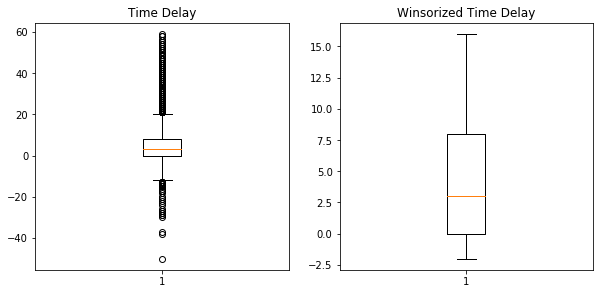

In [491]:
mta['winsor_Time_delay'] = winsorize(mta["Time_delay"], (.1, .1))
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.boxplot(mtaa.Time_delay)
plt.title('Time Delay')
plt.subplot(222)
plt.title('Winsorized Time Delay')
plt.boxplot(mtaa.winsor_Time_delay) 
plt.show()

In [253]:
# create target using winsorized feature
mta['Late_Bus'] = np.where(mta.winsor_Time_delay>7, 1, 0)

In [239]:
mta['day_of_week'] = mta.ScheduledArrivalTime.dt.dayofweek.astype('category')

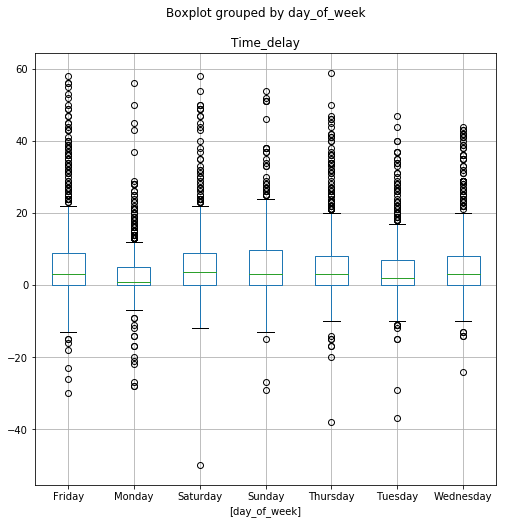

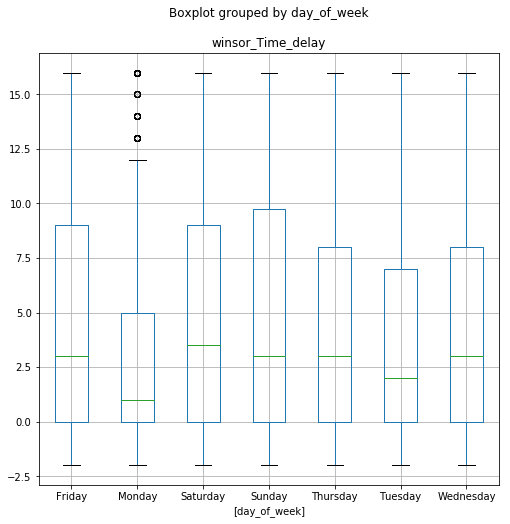

In [502]:
mtaa[['Time_delay','day_of_week']].boxplot(by='day_of_week',figsize=(8,8))
mtaa[['winsor_Time_delay','day_of_week']].boxplot(by='day_of_week',figsize=(8,8))
plt.show()

In [98]:
print('There are',len(mta.VehicleRef.unique()),'busses that service',len(mta.PublishedLineName.unique()),'routes')

There are 4470 busses that service 236 routes


In [1]:
plt.figure(figsize=(15,15))
plt.subplot(221)
sns.countplot(x=mtaa[mtaa.Late_Bus==1].ScheduledArrivalTime.dt.day, data=mtaa[mtaa.Late_Bus<=1], palette="Greens_d")
plt.subplot(222)
sns.countplot(x='day_of_week', data=mtaa[mtaa.Late_Bus==1], palette="Greens_d")
plt.subplot(223)
sns.countplot(x='time_of_day',  data=mtaa[mtaa.Late_Bus==1], palette="Greens_d")
plt.subplot(224)
sns.countplot(x='hours',data=mtaa[mtaa.Late_Bus==1], palette="Greens_d")
plt.show() 

NameError: name 'plt' is not defined

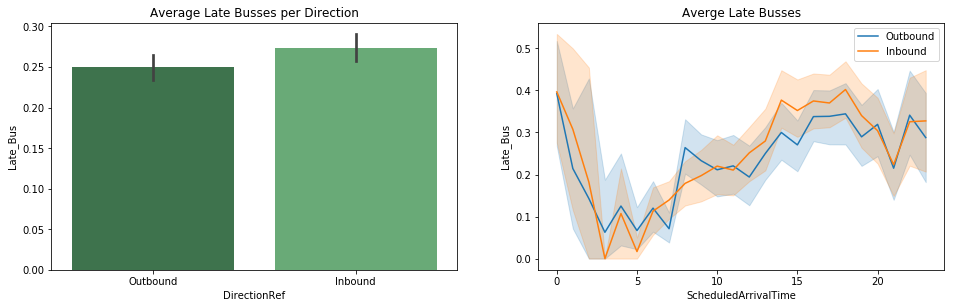

In [547]:
plt.figure(figsize=(16,10))
plt.subplot(221)
sns.barplot(y="Late_Bus", x="DirectionRef", data=mtaa, palette="Greens_d", 
            orient='vertical').set_xticklabels(['Outbound','Inbound'])
plt.title('Average Late Busses per Direction')

plt.subplot(222)
sns.lineplot(mtaa.ScheduledArrivalTime.dt.hour, mtaa.Late_Bus, hue=mtaa.DirectionRef )
plt.legend(['Outbound','Inbound'])
plt.title('Averge Late Busses')
plt.show()

In [563]:
sns.lineplot(mtaa.ScheduledArrivalTime.dt.hour, mtaa.Late_Bus, hue=mtaa.VehicleRef )

ValueError: Image size of 390x71141 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 432x288 with 1 Axes>

In [442]:
stats.ttest_ind(mtaa[mtaa.DirectionRef==0].Late_Bus,mtaa[mtaa.DirectionRef==1].Late_Bus)

Ttest_indResult(statistic=-1.9922847018747565, pvalue=0.046386610703439336)

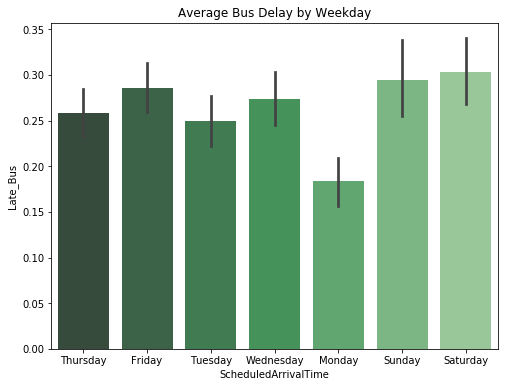

In [476]:
plt.figure(figsize=(8,6))
sns.barplot(mtaa.ScheduledArrivalTime.dt.day_name(), mtaa.Late_Bus,palette="Greens_d")
plt.title('Average Bus Delay by Weekday')
plt.show()

In [3]:
# Test between the means of the percentage of late busses of the days of the week
for i in range(len(mtaa.ScheduledArrivalTime.dt.day_name().unique())):
        for j in range(i+1,7):
            print(mtaa.ScheduledArrivalTime.dt.day_name().unique()[i],' vs ',mtaa.ScheduledArrivalTime.dt.day_name().unique()[j]) 
            print(stats.ttest_ind(
                mtaa[mtaa.ScheduledArrivalTime.dt.day_name()==mtaa.ScheduledArrivalTime.dt.day_name.unique()[i]]['Late_Bus'], 
                mtaa[mtaa.ScheduledArrivalTime.dt.day_name()==mtaa.ScheduledArrivalTime.dt.day_name.unique()[j]]['Late_Bus']))

NameError: name 'mtaa' is not defined

Days that have statistically significant differences in percentage of late busses.

Monday vs Sunday<br/>
Monday vs Tuesday<br/>
Monday vs Wednesday<br/>
Monday vs Thurday<br/>
Monday vs Friday<br/>
Monday vs Saturday<br/>
 
 

   
 
 
 

In [393]:
mtaa.groupby(mtaa.ScheduledArrivalTime.dt.day_name() ).mean()[["Time_delay", "dist_from_stop_in_feet"]][:10]

,Time_delay,dist_from_stop_in_feet
ScheduledArrivalTime,,
Friday,5.818905,807.473809
Monday,3.195730,740.696453
Saturday,6.511182,536.102821
Sunday,6.194323,641.113131
Thursday,5.246525,919.288156
Tuesday,4.619501,853.294078
Wednesday,5.597576,1214.244411


In [20]:
mtaa.groupby(mtaa.ScheduledArrivalTime.dt.day_name()).mean()[['Late_Bus','Time_delay']]

,Late_Bus,Time_delay
ScheduledArrivalTime,,
Friday,0.132552,6.128945
Monday,0.090278,4.275463
Saturday,0.132045,6.510467
Sunday,0.130045,6.594170
Thursday,0.124661,5.652213
Tuesday,0.087224,4.873464
Wednesday,0.126928,5.957295


In [351]:
# 
mtaa['hours'] = mtaa.ScheduledArrivalTime.dt.hour

In [44]:
mtaa['day_of_month'] = mtaa.ScheduledArrivalTime.dt.day

In [276]:
mta['day'] = mta.ScheduledArrivalTime.dt.day

In [356]:
mtaa = pd.concat([mtaa, pd.get_dummies(mtaa.day_of_week.astype('category'),drop_first=True),], axis=1)

In [299]:
mtaa = pd.concat([mtaa, pd.get_dummies(mtaa.time_of_day.astype('category'),drop_first=True),], axis=1)

In [367]:
mtaa = pd.concat([mtaa, pd.get_dummies(mtaa.hours.astype('category'),drop_first=True),], axis=1)

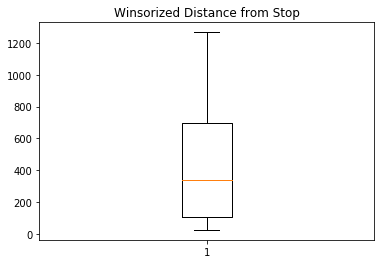

In [474]:
mtaa['winsor_dist'] = winsorize(mtaa["dist_from_stop_in_feet"], (.1, .1))
plt.boxplot(winsorize(mta["dist_from_stop_in_feet"], (.1, .1)))
plt.title('Winsorized Distance from Stop')
plt.show()

In [388]:
features= [  'winsor_dist','day','evening', 'morning',
       'night',1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,'Monday',               'Saturday',
                       'Sunday',               'Thursday',
                      'Tuesday',              'Wednesday',]
       
 
# mta_sample = mta[mta.ScheduledArrivalTime.dt.day<27].sample(frac=.001,random_state=20)
Y = mtaa['Late_Bus'] 
X = mtaa[features].astype(float)


from sklearn.model_selection import train_test_split
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=20)

 # Automatic feature selection with SelectKbest
import sklearn.feature_selection 
#from sklearn.feature_selection import f_regression
select =sklearn.feature_selection.SelectKBest()
selected_features = select.fit(X_train, y_train)
indicies_selected = selected_features.get_support(indices=True)
colnames_selected = [X.columns[i] for i in indicies_selected]
X_selected = X[colnames_selected]
print(colnames_selected)
x_train_selected = X_train[colnames_selected]
x_test_selected = X_test[colnames_selected]

X = mtaa[colnames_selected]
Y = mtaa['Late_Bus']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(x_train_selected) 
X_train = scaler.transform(x_train_selected)
X_test = scaler.transform(x_test_selected)



['winsor_dist', 'day', 'evening', 'morning', 'night', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']


In [389]:
 # Create balanced classes for the training set
import imblearn
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=20)
X_train, y_train = ros.fit_sample(X_train, y_train)


In [390]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn import ensemble 
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

In [391]:
mnb = MultinomialNB() 
neighbors = KNeighborsClassifier(n_neighbors=35) 
decision_tree = tree.DecisionTreeClassifier(max_leaf_nodes=100)
rfc = ensemble.RandomForestClassifier(n_estimators=100,class_weight='balanced') 
svc = SVC(probability=True, gamma='auto') 
lr = LogisticRegression(solver='lbfgs' ) 
clf = ensemble.GradientBoostingClassifier(n_estimators=100)
models = [ neighbors, decision_tree, rfc, lr, svc, clf]
for model in models:
    print(str(model))
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print(confusion_matrix(y_test,y_pred)) 
    print(roc_auc_score(y_test,y_pred))
    print(recall_score(y_test,y_pred))
    print(model.score(X_test,y_test))
    print(classification_report(y_test,y_pred))
    print()

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=35, p=2,
           weights='uniform')
[[462 414]
 [ 95 190]]
0.5970319634703196
0.6666666666666666
0.5615848406546081
              precision    recall  f1-score   support

           0       0.83      0.53      0.64       876
           1       0.31      0.67      0.43       285

   micro avg       0.56      0.56      0.56      1161
   macro avg       0.57      0.60      0.54      1161
weighted avg       0.70      0.56      0.59      1161


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=100,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
[[519 357]
 [120 165]]
0.5857065609228551
0.5789473684210527
0.589147286821